------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [211]:
!python --version

Python 3.10.6


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [6]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
# from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict, Generator, MutableSet
from functools import reduce
import scipy

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [3]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# (1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [4]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [2]:
def read_lexicon(filename: str) -> Tuple[List[List[str]], Dict, Dict]:
    """
        Parameters:
            filename: the file path of the lexicon
        Returns:
            List of shape Nx3, where N is the length of the lexicon and each entry has the following attributes (in this order):
                - word
                - sentiment
                - magnitude
            Dictionary that maps words from the lexicon to the corresponding sentiments
            Dictionary that maps words from the lexicon to the corresponding sentiment magnitudes
    """
    def map_polarity_to_integer(polarity: str) -> int:  
        if polarity == "negative":
            return -1
        elif polarity == "positive":
            return 1
        return 0

    with open(filename, mode="r", encoding="utf-8") as r:
        lexicon = r.readlines()
        
        # remove endline for each line in the lexicon file
        lexicon = [entry.strip("\n") for entry in lexicon] 

        # get every attribute individually
        lexicon = [entry.split(" ") for entry in lexicon]

        # get onyl word, sentiment, and magnitude (remove subj for magnitude)
        lexicon = [[entry[2], entry[-1], entry[0][ : -4]] for entry in lexicon]

        # remove the attrbute marker
        lexicon = [[attribute.split("=")[1] for attribute in line] for line in lexicon]

    # compute sentiments dictionary
    # assign 1 to a positive sentiment and -1 to a negative one 
    sentiments = {entry[0] : map_polarity_to_integer(entry[1]) for entry in lexicon}

    # compute magnitudes dictionary
    # assign 1 to a weak sentiment and 2 to a strong one
    magnitudes = {entry[0] : (1 if entry[2] == "weak" else 2) for entry in lexicon}

    return lexicon, sentiments, magnitudes

def read_dataset(filename: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Parameters:
            filename: the file path of the dataset
        Returns:
            3 numpy arrays:
                1) the sentiment of each document
                2) the documents in the order they appear in filename (only the words without the pos tags)
                3) the documents in the order they appear in filename (only the pos tags without the words)
    """
    with open(filename, mode="r", encoding="utf-8") as r:
        reviews = json.load(r)

    sentiments = []
    documents = []
    documents_pos_tags = []

    for review in reviews:
        document = []
        document_pos_tags = [] 

        for sentence in review["content"]:
            words = []
            pos_tags = []

            # separate the words and pos tags
            for word, pos_tag in sentence:
                words.append(word.lower()) # remove casing for the words in the documents
                pos_tags.append(pos_tag)

            # rebuild the sentence
            document.append(words)
            document_pos_tags.append(pos_tags)

        sentiments.append(1 if review["sentiment"] == "POS" else 0)
        documents.append(document)
        documents_pos_tags.append(document_pos_tags)

    sentiments = np.array(sentiments)
    documents = np.array(documents, dtype=object)
    documents_pos_tags = np.array(documents_pos_tags, dtype=object)

    return sentiments, documents, documents_pos_tags

lexicon, lexicon_sentiments, lexicon_magnitudes = read_lexicon("sent_lexicon")
documents_sentiments, documents, documents_pos_tags = read_dataset("reviews.json")

In [3]:
def basic_binary_lexicon_classification(documents: np.ndarray, documents_sentiments: np.ndarray, lexicon_sentiments: Dict, threshold: int = 8) -> Tuple[List[int], float]:
    """
        Parameters:
            documents: an array containing all the documents to be processed
            documents_sentiments: the respective sentiments of each document
            lexicon_sentiments: a dictionary that maps words to their corresponding prior sentiments
            threshold: the threshold used for classification
        Returns:
            1) a list of 1s and 0s, where 1 means that the classification made by the lexicon-based approach is correct and 0 otherwise
            2) the lexicon-based classification accuracy
    """
    predictions = []
    ground_truth = documents_sentiments

    for document in documents:
        score = 0
        for sentence in document:
            for word in sentence:
                if word in lexicon_sentiments.keys(): # add 0 to the score for words that do not exist in the lexicon
                    score += lexicon_sentiments[word]

        if score > threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    
    accuracy = sk.metrics.accuracy_score(ground_truth, predictions)

    return (predictions == ground_truth), accuracy

# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results, token_accuracy = basic_binary_lexicon_classification(documents, documents_sentiments, lexicon_sentiments)
print("Accuracy: %0.3f" % token_accuracy)

Accuracy: 0.677


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [10]:
def compute_average_score_lexicon_magnitude_approach(documents: np.ndarray, lexicon_sentiments: Dict, lexicon_magnitudes: Dict) -> float:
    """
        Parameters:
            documents: an array containing all the documents to be processed
            lexicon_sentiments: a dictionary that maps words to their corresponding prior sentiments
            lexicon_magnitudes: a dictionary that maps words to their corresponding sentiment magnitudes
        Returns:
            the average score across the documents
    """
    total_score = 0

    for document in documents:
        for sentence in document:
            for word in sentence:
                if word in lexicon_sentiments.keys(): # add 0 to the score for words that do not exist in the lexicon
                    total_score += lexicon_magnitudes[word] * lexicon_sentiments[word]
    
    return total_score / documents.shape[0]

def magnitude_binary_lexicon_classification(documents: np.ndarray, documents_sentiments: np.ndarray, lexicon_sentiments: Dict, lexicon_magnitudes: Dict) -> Tuple[List[int], float]:
    """
        Parameters:
            documents: an array containing all the documents to be processed
            documents_sentiments: the respective sentiments of each document
            lexicon_sentiments: a dictionary that maps words to their corresponding prior sentiments
            lexicon_magnitudes: a dictionary that maps words to their corresponding sentiment magnitudes
        Returns:
            1) a list of 1s and 0s, where 1 means that the classification made by the lexicon-based approach is correct and 0 otherwise
            2) the lexicon-based classification accuracy
    """
    THRESHOLD = 11

    predictions = []
    ground_truth = documents_sentiments

    for document in documents:
        score = 0
        for sentence in document:
            for word in sentence:
                if word in lexicon_sentiments.keys(): # add 0 to the score for words that do not exist in the lexicon
                    score += lexicon_magnitudes[word] * lexicon_sentiments[word]

        if score > THRESHOLD:
            predictions.append(1)
        else:
            predictions.append(0)
    
    accuracy = sk.metrics.accuracy_score(ground_truth, predictions)

    return (predictions == ground_truth), accuracy

print(f"The average score across the documents is: {compute_average_score_lexicon_magnitude_approach(documents, lexicon_sentiments, lexicon_magnitudes)}")

The average score across the documents is: 10.8195


In [11]:
magnitude_results, magnitude_accuracy = magnitude_binary_lexicon_classification(documents, documents_sentiments, lexicon_sentiments, lexicon_magnitudes)
print("Accuracy: %0.3f" % magnitude_accuracy)

Accuracy: 0.696


#### (Q.1.3) Make a barplot of the two results (0.5pt)

<BarContainer object of 2 artists>

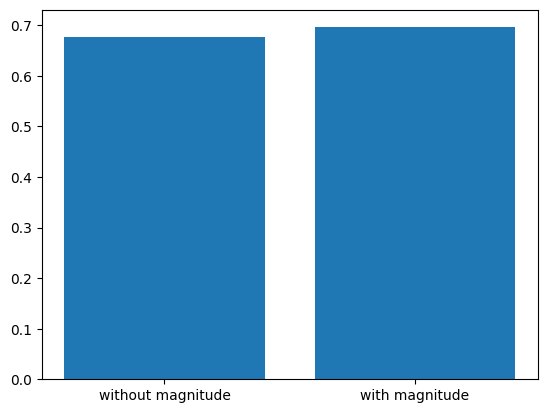

In [220]:
plt.bar(["without magnitude", "with magnitude"], [token_accuracy, magnitude_accuracy])

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

We could receive a short document only containing a few positive words.
In this case it's likely that, although only received positive words, the document is still classified as negative solely because the binary score didn't amount to the threshold.

In [5]:
def compute_threshold_lexicon_doc_length(documents: np.ndarray, lexicon_sentiments: Dict) -> float:
    """
        Parameters:
            documents: an array containing all the documents to be processed
            lexicon_sentiments: a dictionary that maps words to their corresponding prior sentiments
        Returns:
            the average score across the documents
    """
    total_score = 0

    for document in documents:
        document_score = 0
        for sentence in document:
            for word in sentence:
                if word in lexicon_sentiments.keys(): # add 0 to the score for words that do not exist in the lexicon
                    document_score += lexicon_sentiments[word]
        total_score += document_score / len(document)
    
    return total_score / documents.shape[0]

print(f"New threshold: {compute_threshold_lexicon_doc_length(documents, lexicon_sentiments)}")
results, accuracy = basic_binary_lexicon_classification(documents, documents_sentiments, lexicon_sentiments, threshold=1)
print("Accuracy: %0.3f" % accuracy)

New threshold: 0.22473561523462227
Accuracy: 0.634


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

Having information of words only for one sentiment class means having an imbalanced dataset which we fit our model on. Strongly positive words are expected to be seen more often in positive reviews. However, we do expected them to also occur ironically or with a negation in front in negative reviews.
Skipping these words for both classes is a way to 'balance' the dataset.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [4]:
def get_documents_bows(documents: List, documents_sentiments: List) -> List:
    """
        Parameters:
            documents: the documents to be processed
            documents_sentiments: their respective sentiment labels
        Returns:
            1) list that contains the bows for each class
    """
    labels = np.unique(documents_sentiments)
    
    bows = []

    for label in labels:
        # get only the documents relevant for the current label
        current_documents = documents[np.squeeze(np.argwhere(documents_sentiments == label))] 

        # flatten the documents
        concatenated_documents = np.array([])

        for document in current_documents:
            flat_document = np.array(reduce(lambda x, y: x + y, document))
            concatenated_documents = np.concatenate((concatenated_documents, flat_document))

        words, counts = np.unique(concatenated_documents, return_counts=True)

        bow = {}
        for word, count in zip(words, counts):
            bow[word] = count

        bows.append(bow)
        
    return bows

def train_naive_bayes(documents: List, documents_sentiments: List, bows: List, k: int = 0) -> Tuple[List, List, MutableSet]:
    """
        Parameters:
            documents: the documents to be processed
            documents_sentiments: their respective sentiment labels
            bows: the bows for each class
            k: the smoothing value
        Returns:
            1) list that contains the priors of each class
            2) list of dictionaries that map words to their respective conditional probabilities, for each class
            3) the vocabulary containing all the words found in the documents
    """
    vocabulary = set()
    for document in documents:
        document_vocabulary = set(reduce(lambda x, y: x + y, document))
        vocabulary = vocabulary.union(document_vocabulary)

    labels = np.unique(documents_sentiments)

    priors = []
    conditionals = []

    for label in labels:
        # get only the documents relevant for the current label
        current_documents = documents[np.squeeze(np.argwhere(documents_sentiments == label))] 

        prior = len(current_documents) / len(documents)
        priors.append(np.log(prior))

        conditional = {}

        total_vocabulary_occurances = 0
        for word in vocabulary:
            if word in bows[label]:
                total_vocabulary_occurances += bows[label][word]

        for word in vocabulary:
            if word in bows[label]:
                conditional[word] = np.log((bows[label][word] + k) / (total_vocabulary_occurances + k * len(vocabulary)))

        conditionals.append(conditional)

    return priors, conditionals, vocabulary

def classify_naive_bayes(documents: List, priors: List, conditionals: Dict) -> List:
    """
        Parameters:
            documents: the documents to be processed
            priors: list of priors for each class
            conditionals: list of dictionaries that map words to their respective conditional probabilities, for each class
        Returns:
            a list of predictions for each document
    """
    predictions = []

    for document in documents:
        score_0 = priors[0]
        score_1 = priors[1]
        for sentence in document:
            for word in sentence:
                if word in conditionals[0].keys() and word in conditionals[1].keys():
                    score_0 += conditionals[0][word]
                    score_1 += conditionals[1][word]
        
        if score_0 >= score_1:
            predictions.append(0)
        else:
            predictions.append(1)

    return predictions

def split_dataset(documents: List, documents_sentiments: List, negative_training_indices: np.ndarray, negative_testing_indices: np.ndarray, positive_training_indices: np.ndarray, positive_testing_indices: np.ndarray) -> Tuple[List, List, List, List]:
    """
        Parameters:
            documents: the documents to be split
            documents_sentiments: the corresponding sentiment labels
            negative_indices: a list of indices that specify which negative documents should be used for training
            positive_indices: a list of indices that specify which positive documents should be used for training
            negative_training_indices: a list of indices that specify which negative documents should be used for training
            negative_testing_indices: a list of indices that specify which negative documents should be used for testing
            positive_training_indices: a list of indices that specify which positive documents should be used for training
            positive_testing_indices: a list of indices that specify which positive documents should be used for testing
        Returns:
            The trainig/testing split
    """
    negative_documents = documents[ : 1000]
    negative_labels = documents_sentiments[ : 1000]
    positive_documents = documents[1000 : ]
    positive_labels = documents_sentiments[1000 : ]

    negative_training_documents = negative_documents[negative_training_indices]
    negative_training_labels = negative_labels[negative_training_indices]
    negative_testing_documents = negative_documents[negative_testing_indices]
    negative_testing_labels = negative_labels[negative_testing_indices]

    positive_training_documents = positive_documents[positive_training_indices]
    positive_training_labels = positive_labels[positive_training_indices]
    positive_testing_documents = positive_documents[positive_testing_indices]
    positive_testing_labels = positive_labels[positive_testing_indices]

    training_documents = np.concatenate((negative_training_documents, positive_training_documents))
    testing_documents = np.concatenate((negative_testing_documents, positive_testing_documents))
    training_labels = np.concatenate((negative_training_labels, positive_training_labels))
    testing_labels = np.concatenate((negative_testing_labels, positive_testing_labels))

    return training_documents, testing_documents, training_labels, testing_labels

documents_sentiments, documents, _ = read_dataset("reviews.json")
training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(900)), np.array(range(900, 1000)), np.array(range(900)), np.array(range(900, 1000)))

bows = get_documents_bows(training_documents, training_labels)

priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows)
predictions = classify_naive_bayes(testing_documents, priors, conditionals)

accuracy = sk.metrics.accuracy_score(predictions, testing_labels)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

Accuracy is not a good metric in this situation because a classifier that predicts only positive sentiments is going to have 90% accuracy, but we know that only predicting positive sentiments is not a good approach.

In [222]:
documents_sentiments, documents, _ = read_dataset("reviews.json")
training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(90)), np.array(range(900, 910)), np.array(range(900)), np.array(range(900, 1000)))

bows = get_documents_bows(training_documents, training_labels)

priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows)
predictions = classify_naive_bayes(testing_documents, priors, conditionals)

accuracy = sk.metrics.accuracy_score(predictions, testing_labels)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.600


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$ for a word
$w_i$ becomes
$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [223]:
documents_sentiments, documents, _ = read_dataset("reviews.json")
training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(900)), np.array(range(900, 1000)), np.array(range(900)), np.array(range(900, 1000)))

bows = get_documents_bows(training_documents, training_labels)

priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows, k=1)
predictions = classify_naive_bayes(testing_documents, priors, conditionals)

accuracy = sk.metrics.accuracy_score(predictions, testing_labels)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.835


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [224]:
def round_robin_k_fold(no_samples: int, k: int = 10) -> Generator[Tuple[List, List], None, None]:
    """
        Parameters:
            no_samples: the number of input samples
            k: the number of folds
        Returns:
            generator that yields two lists, the training and testing folds for each iteration
    """
    folds = []

    for i in range(k):
        fold = [10 * j + i for j in range(no_samples // k)]
        folds.append(fold)

    for i, testing_fold in enumerate(folds):
        training_fold = folds[ : i] + folds[i + 1 : ]
        training_fold = reduce(lambda x, y: x + y, training_fold)

        yield training_fold, testing_fold

def evaluate_naive_bayes(documents: List, documents_sentiments: List, smoothing: int = 0) -> Tuple[List, float]:
    """
        Parameters:
            documents: the documents to be processed
            documents_sentiments: the respective sentiment labels
            smoothing: the smoothing factor to be used in Naive Bayes
        Returns:
            the list of accuracies for each fold and the mean accuracy across all folds
    """
    accuracies = []

    for training_fold, testing_fold in round_robin_k_fold(len(documents)):
        training_documents = documents[training_fold]
        testing_documents = documents[testing_fold]
        training_labels = documents_sentiments[training_fold]
        testing_labels = documents_sentiments[testing_fold]

        bows = get_documents_bows(training_documents, training_labels)

        priors, conditionals, _ = train_naive_bayes(training_documents, training_labels, bows, k=smoothing)
        predictions = classify_naive_bayes(testing_documents, priors, conditionals)

        accuracy = sk.metrics.accuracy_score(predictions, testing_labels)
        accuracies.append(accuracy)

    return accuracies, sum(accuracies) / len(accuracies)
    
documents_sentiments, documents, _ = read_dataset("reviews.json")
accuracies, accuracy = evaluate_naive_bayes(documents, documents_sentiments, smoothing=1)

print(accuracies, accuracy)

[0.785, 0.85, 0.81, 0.87, 0.8, 0.865, 0.825, 0.79, 0.825, 0.82] 0.8240000000000001


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance. 

In [225]:
def compute_variance(x: List) -> float:
    """
        Parameters:
            x: the list of values the variance has to be computed for
        Returns:
            the variance 
    """
    mean = sum(x) / len(x)
    values = [(value - mean) ** 2 for value in x]

    return sum(values) / len(values)

print("Variance: %0.5f" % compute_variance(accuracies))

Variance: 0.00079


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [226]:
def apply_stemming(documents: List) -> List:
    """
        Parameters:
            documents: the documents to be processed
        Returns:
            The documents after applying Porter stemming on the words
    """

    stemmer = PorterStemmer()

    new_documents = []
    for document in documents:
        new_sentences = []

        for sentence in document:
            new_words = []

            for word in sentence:
                new_word = stemmer.stem(word) # stemming
                new_words.append(new_word)

            new_sentences.append(new_words)

        new_documents.append(new_sentences)
    
    return np.array(new_documents, dtype=object)

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [227]:
documents_sentiments, documents, _ = read_dataset("reviews.json")
documents = apply_stemming(documents)
_, accuracy = evaluate_naive_bayes(documents, documents_sentiments, smoothing=1)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.818


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [228]:
documents_sentiments, documents, _ = read_dataset("reviews.json")

training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(900)), np.array(range(900, 1000)), np.array(range(900)), np.array(range(900, 1000)))
bows = get_documents_bows(training_documents, training_labels)
priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows, k=1)

print(f"The size of the vocabulary without stemming: {len(vocabulary)}")

documents = apply_stemming(documents)
training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(900)), np.array(range(900, 1000)), np.array(range(900)), np.array(range(900, 1000)))
bows = get_documents_bows(training_documents, training_labels)
priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows, k=1)

print(f"The size of the vocabulary with stemming: {len(vocabulary)}")

The size of the vocabulary without stemming: 45348
The size of the vocabulary with stemming: 32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [229]:
def compute_ngrams(documents: List, n: int) -> List:
    """
        Parameters:
            documents: the documents to be processed i.e. each sentence is going to be replaced by a list of ngrams (unigrams+bigrams+...+ngrams)
            n: the maximum ngram length
        Returns:
            the new documents with the sentences replaced by lists of ngrams
    """
    new_documents = []
    for document in documents:
        new_document = []
        for sentence in document:
            new_sentence = []
            for i in range(1, n + 1):
                new_sentence += ngrams(sentence, i)
            
            new_document.append(new_sentence)

        new_documents.append(new_document)

    return np.array(new_documents, dtype=object)

for i in range(2, 4):
    documents_sentiments, documents, _ = read_dataset("reviews.json")
    documents = compute_ngrams(documents, i)

    _, accuracy = evaluate_naive_bayes(documents, documents_sentiments, smoothing=1)
    print(f"Accuracy {accuracy} using up to {i}-grams")

Accuracy 0.829 using up to 2-grams
Accuracy 0.8145 using up to 3-grams



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


For a sentence of length N, the number of unigrams is N, the number of bigrams is N - 1 and the number of trigrams is N - 2. Considering this, we would expected the number of Bow features to increase linearily. The number of features for the stemming approach should be less than the number of features for the approach without stemming, and in turn much less than the number of features for the ngram approach.

The size of the vocabulary without stemming: 45348

The size of the vocabulary with stemming: 32404

The size of the vocabulary with unigrams: 45348

The size of the vocabulary with unigrams+bigrams: 465262

The size of the vocabulary with unigrams+bigrams+trigrams: 1346107

In [230]:
documents_sentiments, documents, _ = read_dataset("reviews.json")

training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(900)), np.array(range(900, 1000)), np.array(range(900)), np.array(range(900, 1000)))
bows = get_documents_bows(training_documents, training_labels)
priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows, k=1)

print(f"The size of the vocabulary with unigrams: {len(vocabulary)}")

documents = compute_ngrams(documents, 2)
training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(900)), np.array(range(900, 1000)), np.array(range(900)), np.array(range(900, 1000)))
bows = get_documents_bows(training_documents, training_labels)
priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows, k=1)

print(f"The size of the vocabulary with unigrams+bigrams: {len(vocabulary)}")

documents_sentiments, documents, _ = read_dataset("reviews.json")
documents = compute_ngrams(documents, 3)
training_documents, testing_documents, training_labels, testing_labels = split_dataset(documents, documents_sentiments, np.array(range(900)), np.array(range(900, 1000)), np.array(range(900)), np.array(range(900, 1000)))
bows = get_documents_bows(training_documents, training_labels)
priors, conditionals, vocabulary = train_naive_bayes(training_documents, training_labels, bows, k=1)

print(f"The size of the vocabulary with unigrams+bigrams+trigrams: {len(vocabulary)}")

The size of the vocabulary with unigrams: 45348
The size of the vocabulary with unigrams+bigrams: 465262
The size of the vocabulary with unigrams+bigrams+trigrams: 1346107


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [231]:
def get_count_vectorizer(training_documents: List) -> sk.feature_extraction.text.CountVectorizer:
    """
        Parameters:
            training_documents: the documents used for training the svm model
        Returns:
            a CountVectorizer that will be used to transform the data at training/inference time
    """
    documents = []
    for document in training_documents:
        flat_document = reduce(lambda x, y: x + y, document)
        documents.append(" ".join(flat_document))

    count_vectorizer = sk.feature_extraction.text.CountVectorizer(lowercase=False).fit(documents)

    return count_vectorizer

def svm_process_documents(documents: List, count_vectorizer: sk.feature_extraction.text.CountVectorizer) -> scipy.sparse._csr.csr_matrix:
    new_documents = []
    for document in documents:
        flat_document = reduce(lambda x, y: x + y, document)
        new_documents.append(" ".join(flat_document))

    return count_vectorizer.transform(new_documents)

def evaluate_svm(documents: List, documents_sentiments: List) -> Tuple[List, float]:
    """
        Parameters:
            documents: the documents to be processed
            documents_sentiments: the respective sentiment labels
        Returns:
            list of accuracies for each fold and the mean of accuracies across all folds
    """
    accuracies = []

    for training_fold, testing_fold in round_robin_k_fold(len(documents)):
        training_documents = documents[training_fold]
        testing_documents = documents[testing_fold]
        training_labels = documents_sentiments[training_fold]
        testing_labels = documents_sentiments[testing_fold]

        count_vectorizer = get_count_vectorizer(training_documents)
        training_data = svm_process_documents(training_documents, count_vectorizer)

        svm = sk.svm.LinearSVC(dual=False)
        svm.fit(training_data, training_labels)

        testing_data = svm_process_documents(testing_documents, count_vectorizer)
        predictions = svm.predict(testing_data)

        accuracy = sk.metrics.accuracy_score(predictions, testing_labels)
        accuracies.append(accuracy)

    return accuracies, sum(accuracies) / len(accuracies)

documents_sentiments, documents, _ = read_dataset("reviews.json")

_, accuracy = evaluate_svm(documents, documents_sentiments)
print("SVM accuracy: %0.3f" % accuracy)

_, accuracy = evaluate_naive_bayes(documents, documents_sentiments, smoothing=1)
print("Naive Bayes accuracy: %0.3f" % accuracy)

SVM accuracy: 0.839
Naive Bayes accuracy: 0.824


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



#### (Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [232]:
def add_pos_tags(documents: List, documents_pos_tags: List, pos_tag_filter: MutableSet = {}) -> List:
    """
        Parameters:
            documents: the documents to be processed
            documents_pos_tags: a list with the same shape as document but instead of words in contains the respective POS tags
            pos_tag_filter: a set of POS tags of interest (if [] then no filter is applied)
        Returns:
            the list of documents where each word has the respective POS tag appended
    """
    new_documents = []

    for document, pos_tag_document in zip(documents, documents_pos_tags):
        new_document = []
        for sentence, pos_tag_sentence in zip(document, pos_tag_document):
            new_sentence = []
            for word, pos_tag in zip(sentence, pos_tag_sentence):
                if pos_tag_filter != {}:
                    if pos_tag in pos_tag_filter:
                        new_word = word + pos_tag
                        sentence.append(new_word)
                else:
                    new_word = word + pos_tag
                    new_sentence.append(new_word)
            new_document.append(new_sentence)
        new_documents.append(new_document)
    
    return np.array(new_documents, dtype=object)

documents_sentiments, documents, documents_pos_tags = read_dataset("reviews.json")
documents = add_pos_tags(documents, documents_pos_tags)

_, accuracy = evaluate_svm(documents, documents_sentiments)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.841


*Write your answer here.*

Accuracy: 

- avg SVM : 0.839
- avg Naive Bayes: 0.824
- avg SVM + POS tags: 0.841

Including part-of-speech information helps the SVM classifier in reaching a higher cross-fold
validation score. Using the POS tag we could tackle the word sense disambiguation.
This helps the classifier distinguish between the sentiment in the word 'love' in the sentence "I love this movie" (positive) and the sentence "This is a love story" (neutral). 


#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [233]:
pos_tags = {
    "JJ",
    "JJR",
    "JJS",
    "RB",
    "RBR",
    "RBS",
    "NNS",
    "NN",
    "VBN",
    "VBG",
    "VBD",
    "VBP",
    "VBZ",
    "NNPS",
    "NNP",
    "VB",
    "WRB",
    "MD"
}

documents_sentiments, documents, documents_pos_tags = read_dataset("reviews.json")
documents = add_pos_tags(documents, documents_pos_tags)

_, accuracy = evaluate_svm(documents, documents_sentiments)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.841


Accuracy: 
- avg SVM : 0.839
- avg Naive Bayes: 0.824
- avg SVM + POS tags: 0.841
-  avg SVM + POS tags + removed closed-class: 0.842

We expect that discarding all closed-class words from the data results in better performance.

The closed classes include pronouns, determiners, conjunctions, and prepositions, whereas open-class words include nouns, lexical verbs, adjectives, and adverbs.


The closed classes represent a more restricted range of meanings, which tend to be less detailed than open-class words.

The sentiment of these closed words is something less pronounced or a bit ambiguous relative to open words which more often have a distinct sentiment. Removing ambiguity by discarding all closed-class words and using POS-tags, is expected to result in a better classifier. 


# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.

The lexicon-based approach is simpler and faster to compute but does not reach the accuracy of the other approaches. Here we only looked at the occurrence of a word to calculate a certain binary score for a given document, which yields an accuracy of 0.677 with the set threshold of 8. For the magnitude approach, the average score across the documents is calculated (thres=10.8, so the new threshold is 11) and results in a classifier accuracy of 0.696. A new method we used to define a new threshold for this approach is to incorporate document length into our calculations, which we have accomplished by dividing the score for each document by the document length and getting the average across all the documents. With this approach we obtain the new thresh 0.22, but we round it up. However, this new threshold (q1.4) does not yield a better classifier.

The Naive Bayes approach reaches a far better accuracy by also taking conditional probability and prior into account as features. Using smoothing we can further increase the accuracy. To make the algorithm more robust, stemming is used to project different inflections of a word to the same feature in the bag of words vector space. Against expectation, this does not improve classifier accuracy. A negative side of stemming is that we remove some inflections of a word resulting in a smaller vocab and thus less detailed information. Using n-grams as features, we can tackle cases where our classifier only sees a positive word like good, but does not see the negation just before this word. This improves the accuracy greatly.

Including POS-tags counters ambiguity, the experiments are detailed in Q3.2. Using the Support Vector Machines algorithm as our classifier results in a better accuracy score compared to the Naive Bayes (NB) approach. NB depends on conditional probabilities which are easier and faster to implement and evaluate. NB assumes that features are independent conditioned on the class of interest, but this assumption does not always hold hence the name Naive of the algorithm. SVM is more expressive in classifying non-linearly separable data, but requires an iterative process and thus is more computationally expensive. This results in a slightly higher accuracy (0.842) compared to NB (0.824). Based on these experiments it can be concluded that the Naive Bayes is the best classifier in terms of its computational cost and accuracy ratio.


# Submission 


In [234]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

# Erencan Tatar - 12681598
# Andrei Blahovici - 14532921

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 